<a href="https://colab.research.google.com/github/A-tavv/imbalanced-model-evaluation/blob/main/Evaluation_Model_Performance_On_Imbalanced_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import f1_score

untouchedData =  pd.read_csv('waveform.data', sep=",", header=None)
x = untouchedData.drop(columns=[21])
y = untouchedData[21]
testDataIndex = untouchedData.sample(1000).index
testData = untouchedData.loc[testDataIndex]
data = untouchedData.drop(index=testDataIndex)
xTrain = data.drop(columns=[21])
yTrain = data[21]
xTest = testData.drop(columns=[21])
yTest = testData[21]

## Part 1


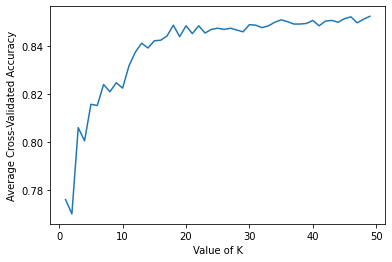

Maximum accuracy 0.8524999999999998 with k=49


In [ ]:
%matplotlib inline
# choose k between 1 to 31
kRange = range(1, 50)
kScores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in kRange:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm="brute")
    scores = cross_val_score(knn, xTrain, yTrain, cv=5, scoring='accuracy')
    kScores.append(scores.mean())
# plot for visual comparison
plt.plot(kRange, kScores)
plt.xlabel('Value of K')
plt.ylabel('Average Cross-Validated Accuracy')
plt.show()
print("Maximum accuracy "+str(max(kScores))+" with k="+str(kRange[kScores.index(max(kScores))]))

## Part 2

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
knn.fit(xTrain, yTrain)
print('Accuracy before data reduction: ', knn.score(xTest, yTest))
changeMade = True
x1, x2, y1, y2 = train_test_split(xTrain, yTrain, test_size=0.5, random_state=1)
dataCleaningKnn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
# Step 1
while changeMade:
    x1.reset_index(drop=True, inplace=True)
    x2.reset_index(drop=True, inplace=True)
    y1.reset_index(drop=True, inplace=True)
    y2.reset_index(drop=True, inplace=True)
    initialSize = len(y1) + len(y2)

    dataCleaningKnn.fit(x2, y2)
    prediction = dataCleaningKnn.predict(x1)
    removeList = []
    for i in range(len(prediction)):
        if prediction[i] != y1[i]:
            removeList.append(i)
    x1.drop(index=removeList, inplace=True)
    y1.drop(index=removeList, inplace=True)


    dataCleaningKnn.fit(x1, y1)
    prediction = dataCleaningKnn.predict(x2)
    removeList = []
    for i in range(len(prediction)):
        if prediction[i] != y2[i]:
            removeList.append(i)
    x2.drop(index=removeList, inplace=True)
    y2.drop(index=removeList, inplace=True)

    if len(y1) + len(y2) == initialSize:
        changeMade = False

newX = pd.concat([x1, x2], ignore_index=True, axis=0)
newY = pd.concat([y1, y2], ignore_index=True, axis=0)
knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
knn.fit(newX, newY)

print('Accuracy after first step: ', knn.score(xTest, yTest))

# Second step
changeMade = True
goodOnes = []
goodOnes.append(random.randint(0,len(newY)))
while changeMade:
    changeMade = False
    for i in newX.index:
        if i in goodOnes:
            goodOnes.remove(i)
            dataCleaningKnn.fit(newX.loc[goodOnes], newY.loc[goodOnes])
            goodOnes.append(i)
        else:
            dataCleaningKnn.fit(newX.loc[goodOnes], newY.loc[goodOnes])
        if dataCleaningKnn.predict([newX.loc[i]])[0] != newY.loc[i]:
            if i not in goodOnes:
                goodOnes.append(i)
                changeMade = True
        else:
            if i in goodOnes:
                goodOnes.remove(i)
                changeMade = True
        print("\rNumber of good samples at this stage: "+str(len(goodOnes)), end="")

knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
knn.fit(newX.loc[goodOnes], newY.loc[goodOnes])
print()
print('The final accuracy: ', knn.score(xTest, yTest))

Accuracy before data reduction:  0.801
Accuracy after first step:  0.812
Number of good samples at this stage: 578
The final accuracy:  0.765


## Part 3

In [ ]:
# Not testing the accuracy -> Using all the data for train and prediction since the performances are in O(n^2) vs O(n*logn) and not that much difference in small n
# Brute Force
knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
start = datetime.now()
knn.fit(x, y)
lenght = int((datetime.now() - start).total_seconds()*100000)/100

print("Brute Force:")
print("Training time: "+str(lenght)+"ms")

start = datetime.now()
knn.predict(x)
lenght = int((datetime.now() - start).total_seconds()*100000)/100

print("Test time: "+str(lenght)+"ms")
print("_"*40)

# Ball Tree
knn = KNeighborsClassifier(n_neighbors=1, algorithm="ball_tree")
start = datetime.now()
knn.fit(x, y)
lenght = int((datetime.now() - start).total_seconds()*100000)/100

print("Ball Tree:")
print("Training time: "+str(lenght)+"ms")

start = datetime.now()
knn.predict(x)
lenght = int((datetime.now() - start).total_seconds()*100000)/100

print("Test time: "+str(lenght)+"ms")
print("_"*40)

# KD Tree
knn = KNeighborsClassifier(n_neighbors=1, algorithm="kd_tree")
start = datetime.now()
knn.fit(x, y)
lenght = int((datetime.now() - start).total_seconds()*100000)/100

print("KD Tree:")
print("Training time: "+str(lenght)+"ms")

start = datetime.now()
knn.predict(x)
lenght = int((datetime.now() - start).total_seconds()*100000)/100

print("Test time: "+str(lenght)+"ms")

Brute Force:
Training time: 3.54ms
Test time: 579.04ms
________________________________________
Ball Tree:
Training time: 11.26ms
Test time: 507.23ms
________________________________________
KD Tree:
Training time: 14.36ms
Test time: 152.47ms


## Part 4

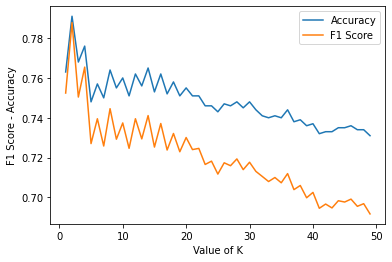

In [ ]:
totalDataCount = data[data[21]==0].shape[0]
classIndexes = data[data[21]==0].sample(int(totalDataCount*0.8)).index
unbalanceData = data.drop(index=classIndexes)

xTrain = unbalanceData.drop(columns=[21])
yTrain = unbalanceData[21]

kRange = range(1, 50)
f1Scores = []
kScores = []
# use iteration to caclulator different k in models, then return the average accuracy and f1 score
for k in kRange:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm="brute")
    knn.fit(xTrain, yTrain)
    f1Score = f1_score(yTest, knn.predict(xTest), average='weighted')
    accuracy = knn.score(xTest, yTest)
    f1Scores.append(f1Score)
    kScores.append(accuracy)
# plot for visual comparison
plt.plot(kRange, kScores,label="Accuracy")
plt.plot(kRange, f1Scores, label="F1 Score")
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('F1 Score - Accuracy')
plt.show()